# CINEMA-OT

CINEMA-OT is a causal-inference-based method for single-cell perturbation analysis, utilizing optimal transport to separate confounding variation from actual perturbation effects, enabling the identification of counterfactual cell pairs that reflect true causal responses {cite}`Dong2023`.
This approach facilitates advanced analyses like individual treatment-effect assessment, response clustering, and synergy analysis, proving more effective than existing methods in benchmark studies across simulated and real datasets.

In this tutorial, we demonstrate how to use CINEMA-OT to reveal the perturbation effect induced by IFNb treatment on PBMC immune cells.
We provide a minimal example dataset (1000 cells) that reproduces consistent results in the corresponding [paper](https://www.nature.com/articles/s41592-023-02040-5) (Figure 5E).

## Setup

In [1]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pertpy as pt
import scanpy as sc

plt.rcParams["figure.dpi"] = 250
plt.rcParams["font.size"] = 15

## Dataset

In [2]:
adata = pt.dt.cinemaot_example()

In [3]:
adata

AnnData object with n_obs × n_vars = 1000 × 773
    obs: 'perturbation', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'leiden', 'cell_type0528'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'cell_type0528_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'perturbation_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'cf'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

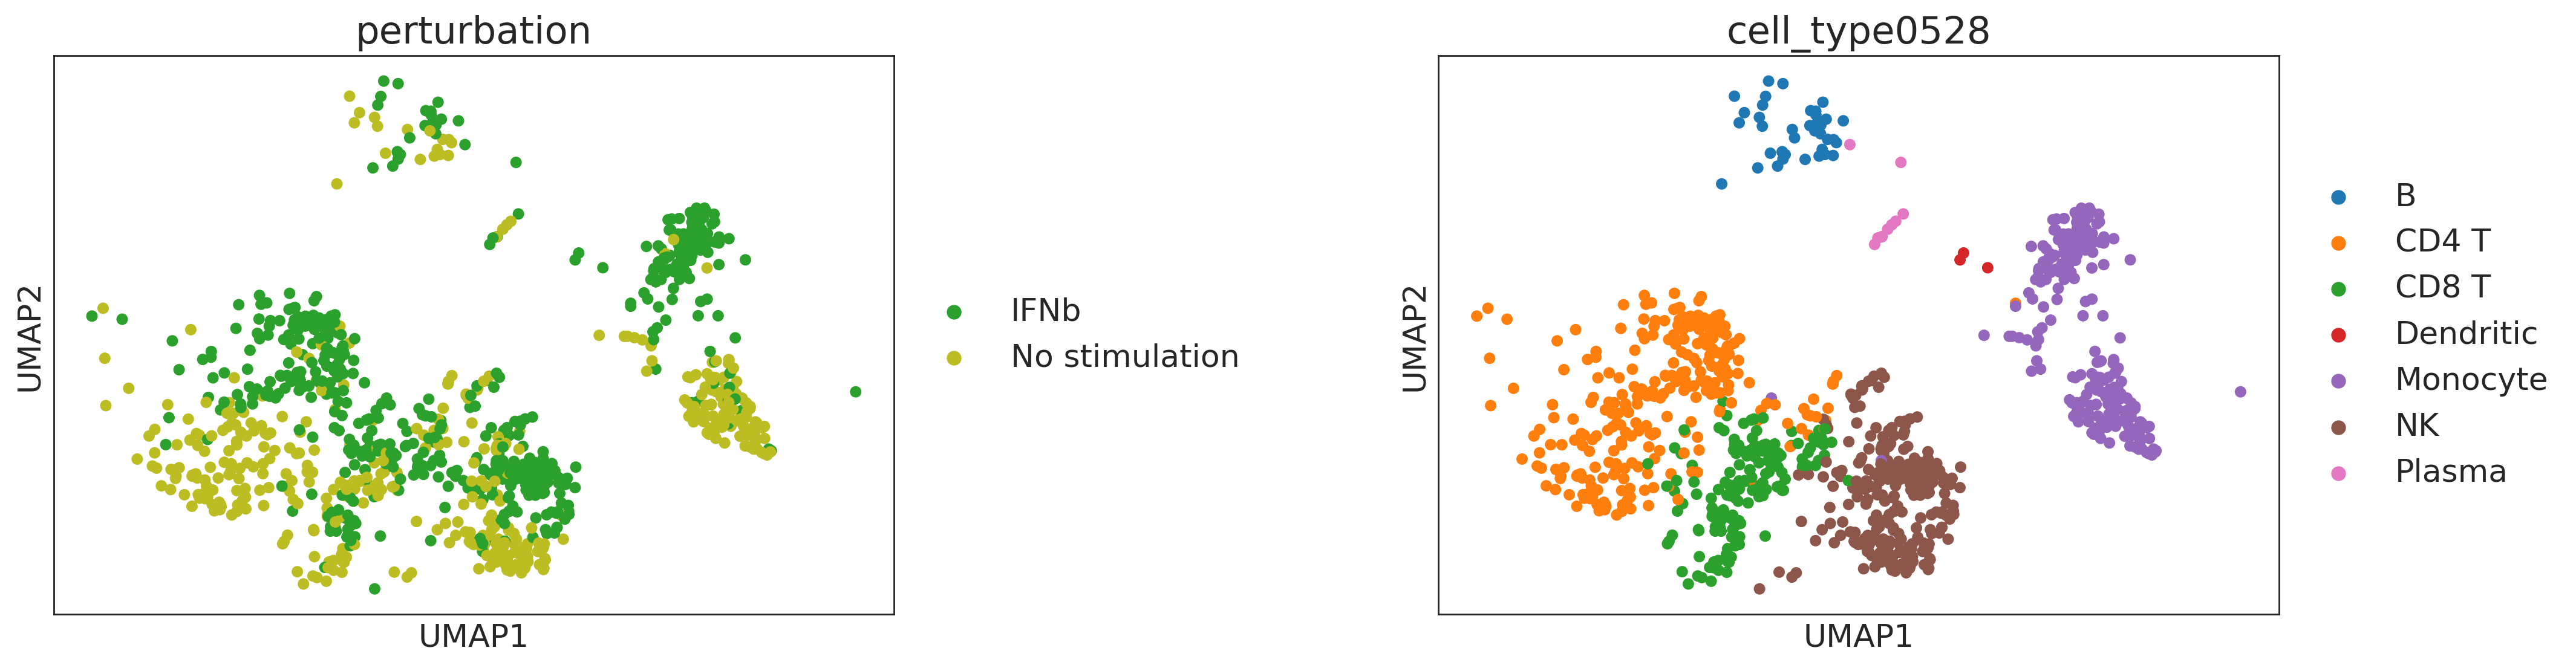

In [4]:
sc.pl.umap(adata, color=["perturbation", "cell_type0528"], wspace=0.5)

## CINEMA-OT treatment effect analysis

First we perform CINEMA-OT analysis applying the annotated cell type label. CINEMA-OT returns a confounder embedding in the original `adata.obsm['cf']`, and a new anndata object `de` that includes the single-cell level treatment effect matrix `de.X`, and the low dimensional embedding `de.obsm['X_embedding']`. If `return_matching is set to True, the model also returns the matching matrix in `de.obsm['ot']`.

In [5]:
cot = pt.tl.Cinemaot()
sc.pp.pca(adata)
de = cot.causaleffect(
    adata,
    pert_key="perturbation",
    control="No stimulation",
    return_matching=True,
    thres=0.5,
    smoothness=1e-5,
    eps=1e-3,
    solver="Sinkhorn",
    preweight_label="cell_type0528",
)

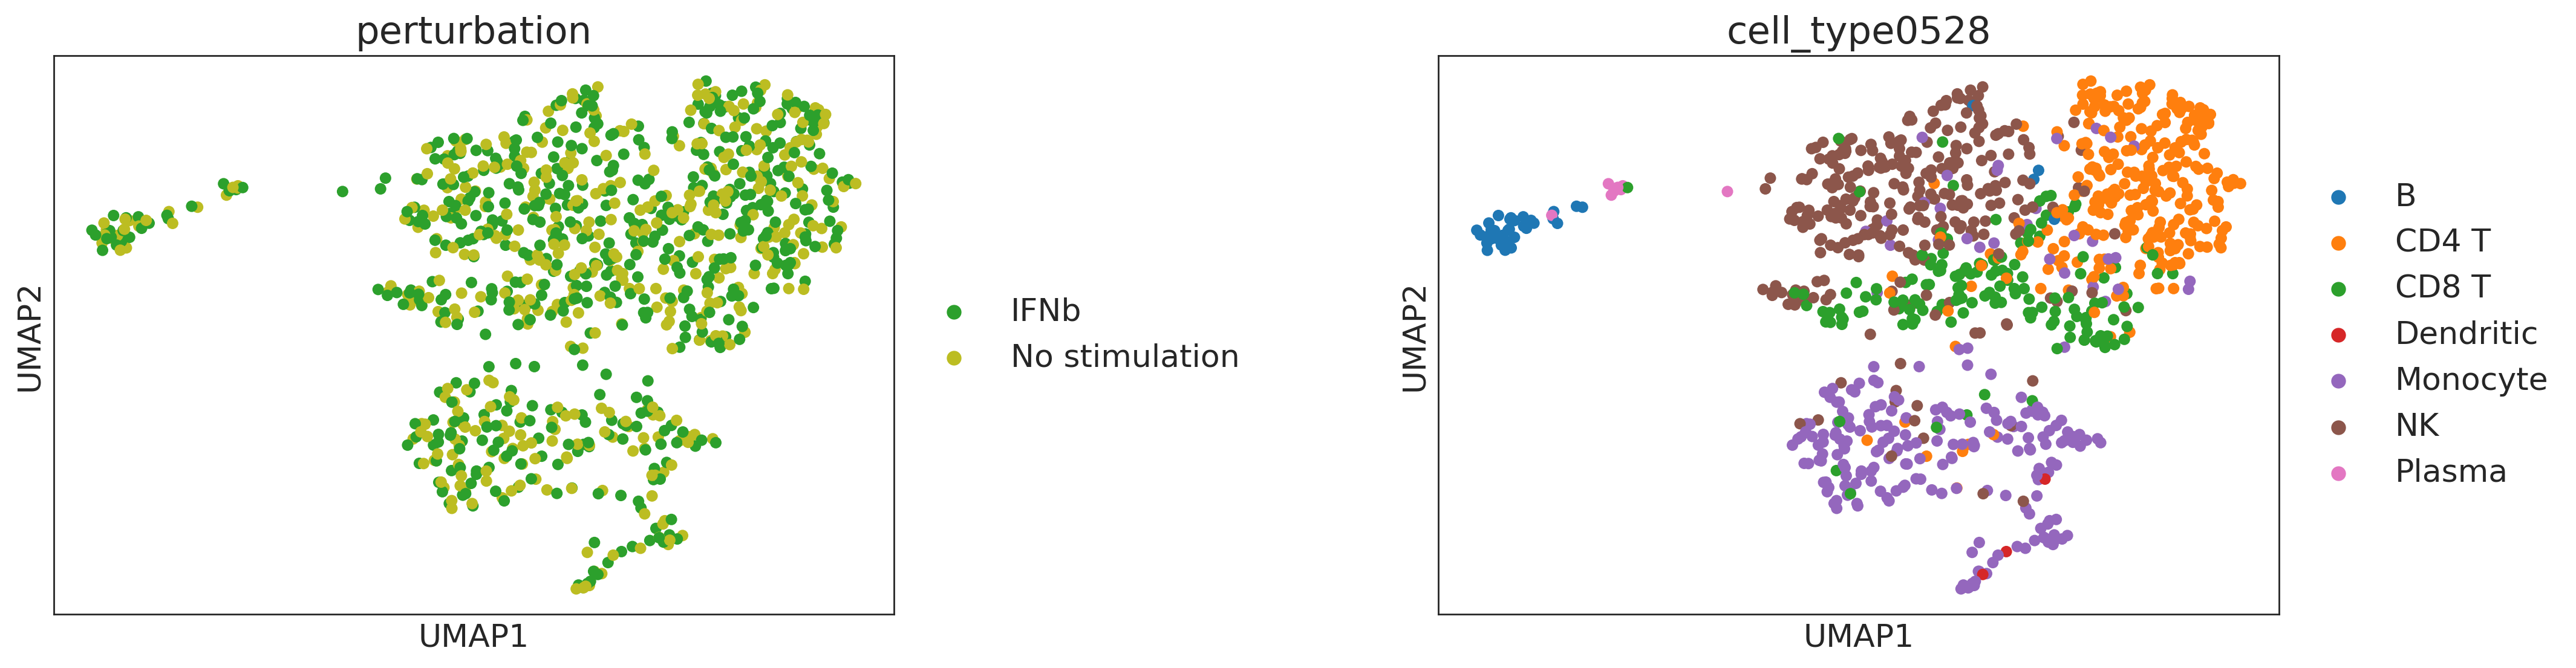

In [6]:
sc.pp.neighbors(adata, use_rep="cf")
sc.tl.umap(adata, random_state=1)
sc.pl.umap(adata, color=["perturbation", "cell_type0528"], wspace=0.5)

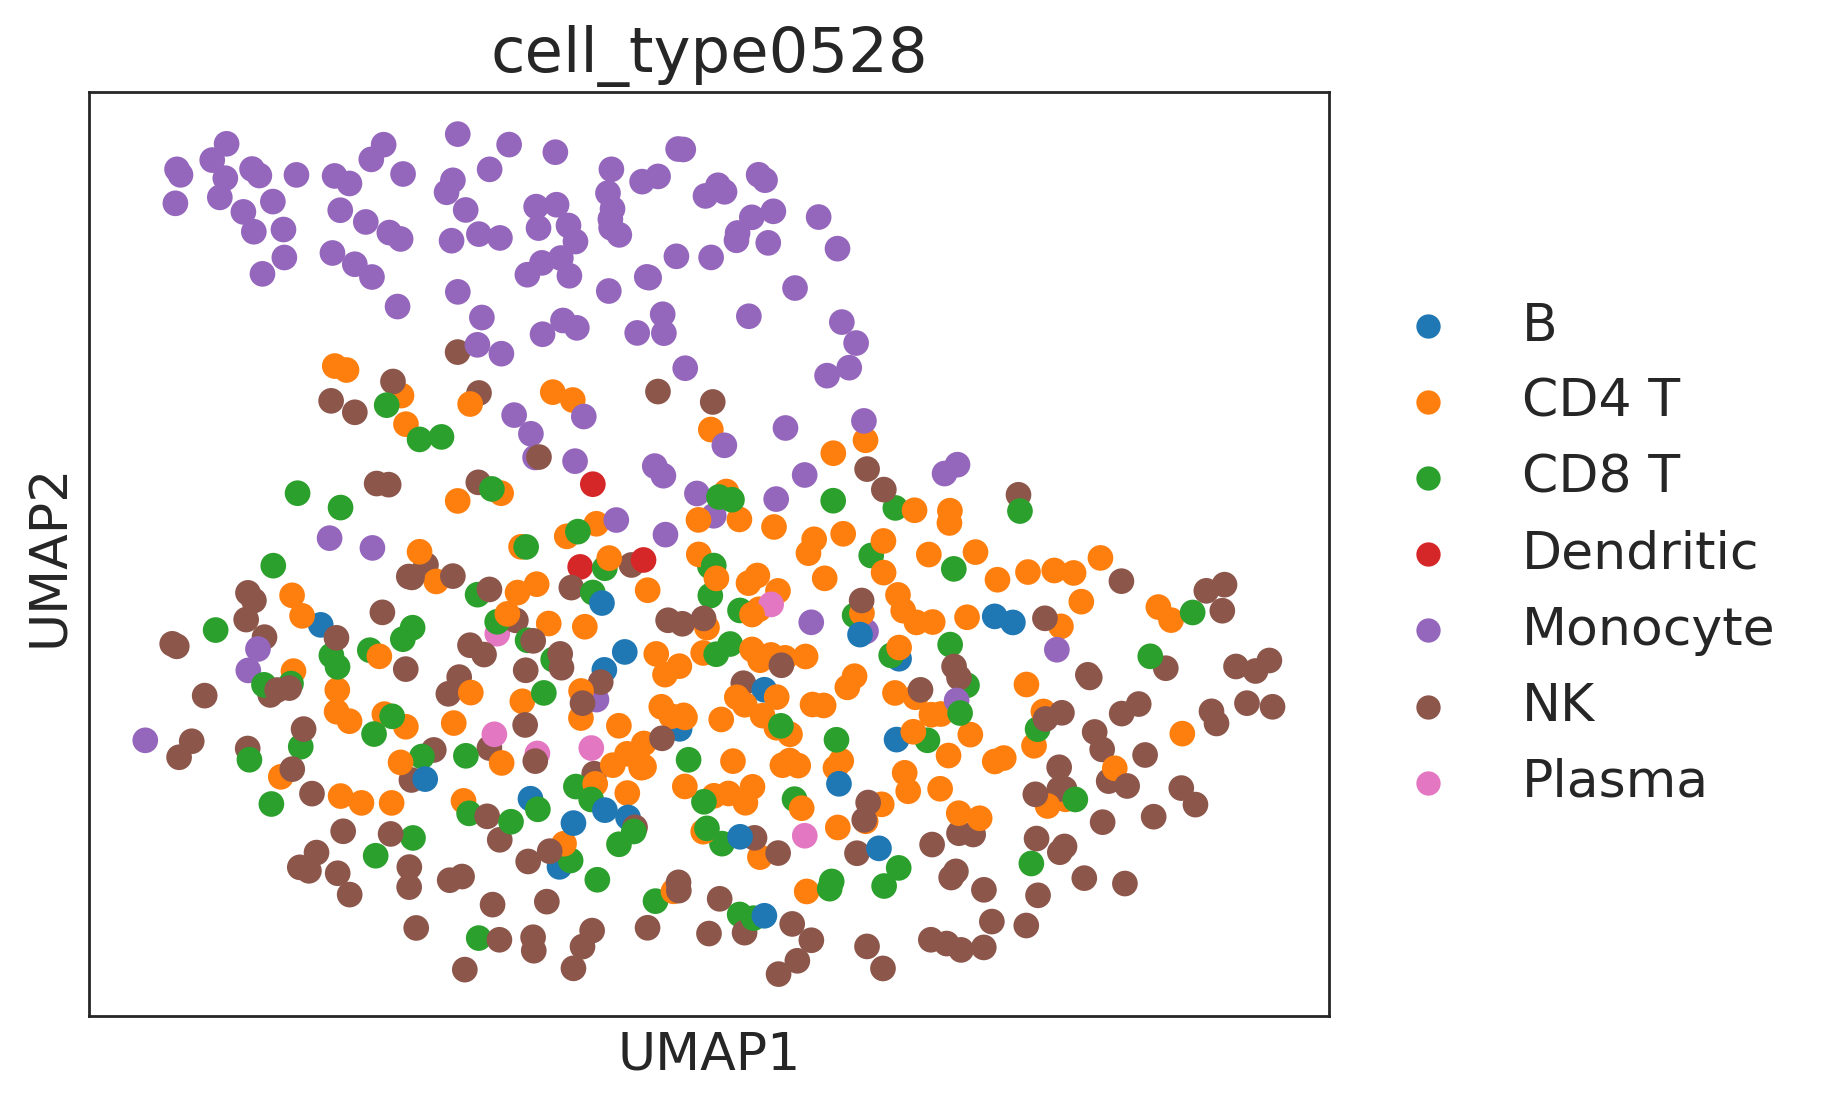

In [7]:
sc.pp.neighbors(de, use_rep="X_embedding")
sc.tl.umap(de)
sc.pl.umap(de, color=["cell_type0528"])

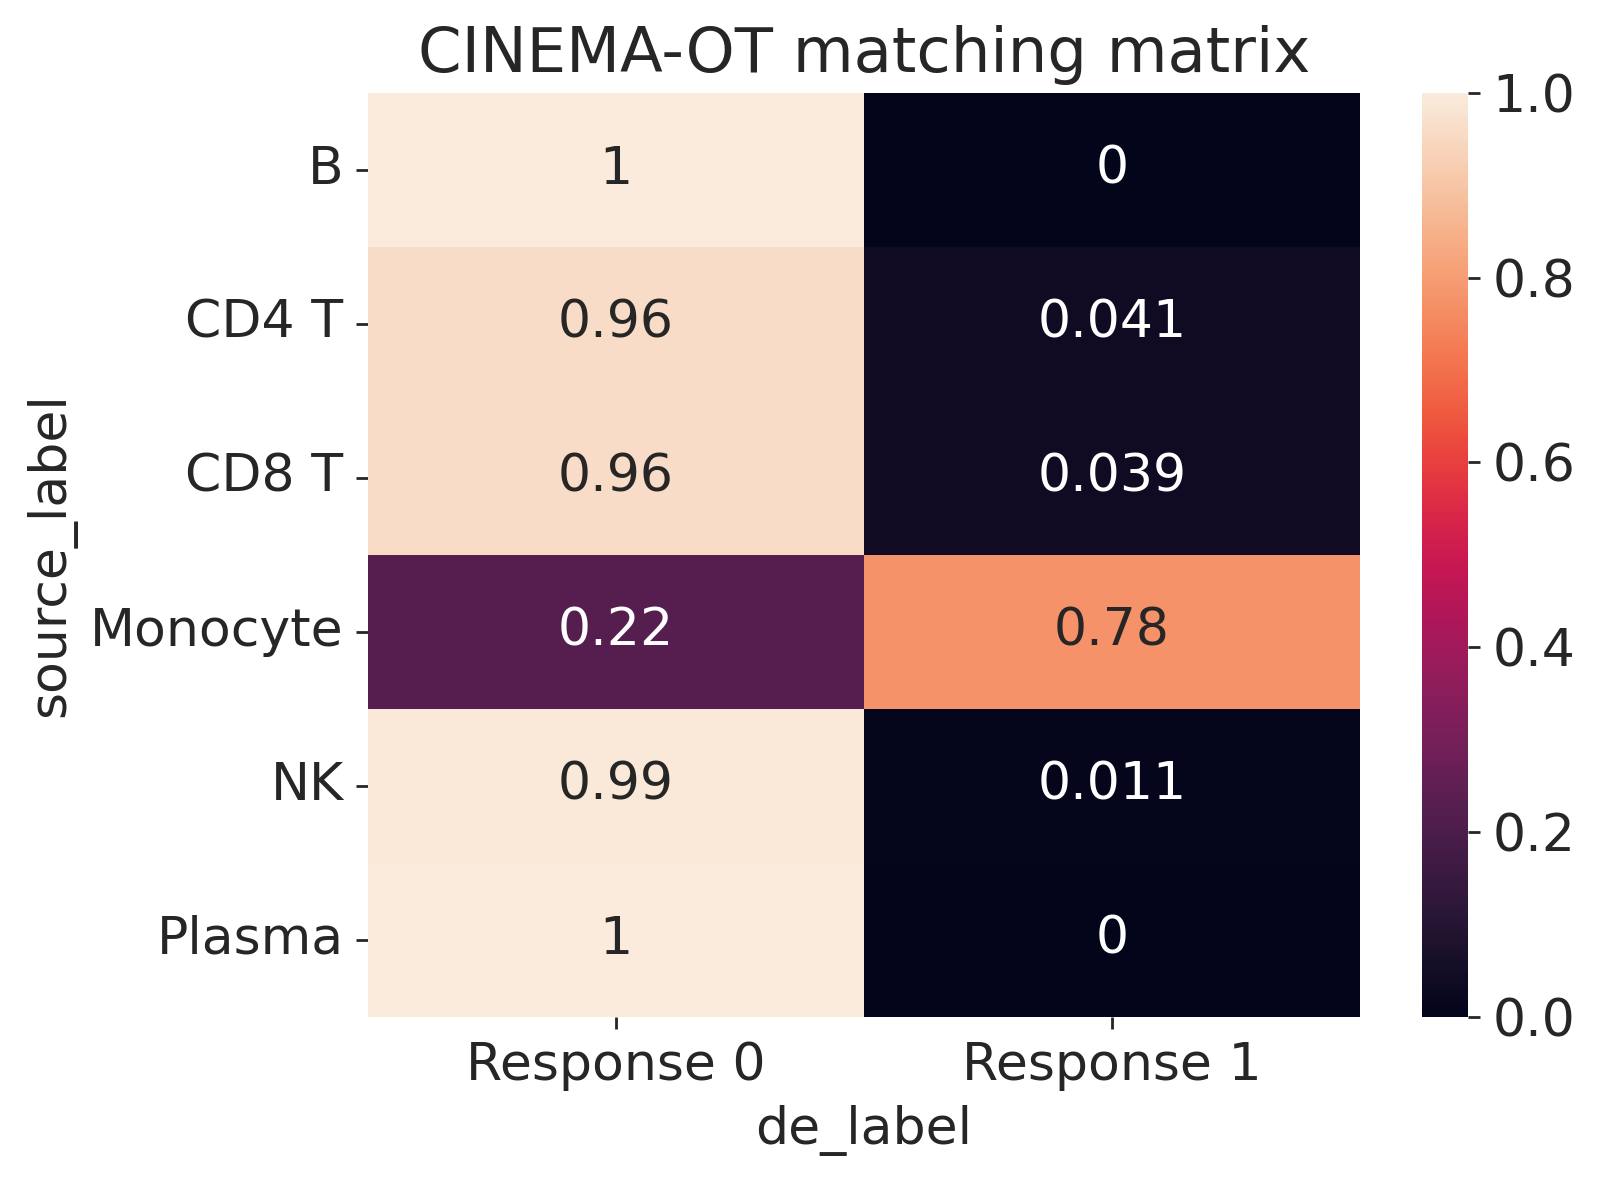

In [8]:
cot.plot_vis_matching(
    adata,
    de,
    pert_key="perturbation",
    control="No stimulation",
    de_label=None,
    source_label="cell_type0528",
    normalize="row",
    min_val=0.05,
)

Next, we perform CINEMA-OT analysis using the CINEMA-OT-W approach.
This approach estimate the confounder abundance in an unsupervised fashion and returns the subsampled AnnData object as well as the corresponding treatment effect AnnData object.
The format of output is consistent with the original approach above.
We see in practice the approach generates very similar results compared with the result above with prior annotated cell type labels.

In [9]:
cot = pt.tl.Cinemaot()
sc.pp.pca(adata)
ad, de = cot.causaleffect_weighted(
    adata,
    pert_key="perturbation",
    control="No stimulation",
    return_matching=True,
    thres=0.5,
    smoothness=1e-5,
    eps=1e-3,
    solver="Sinkhorn",
)

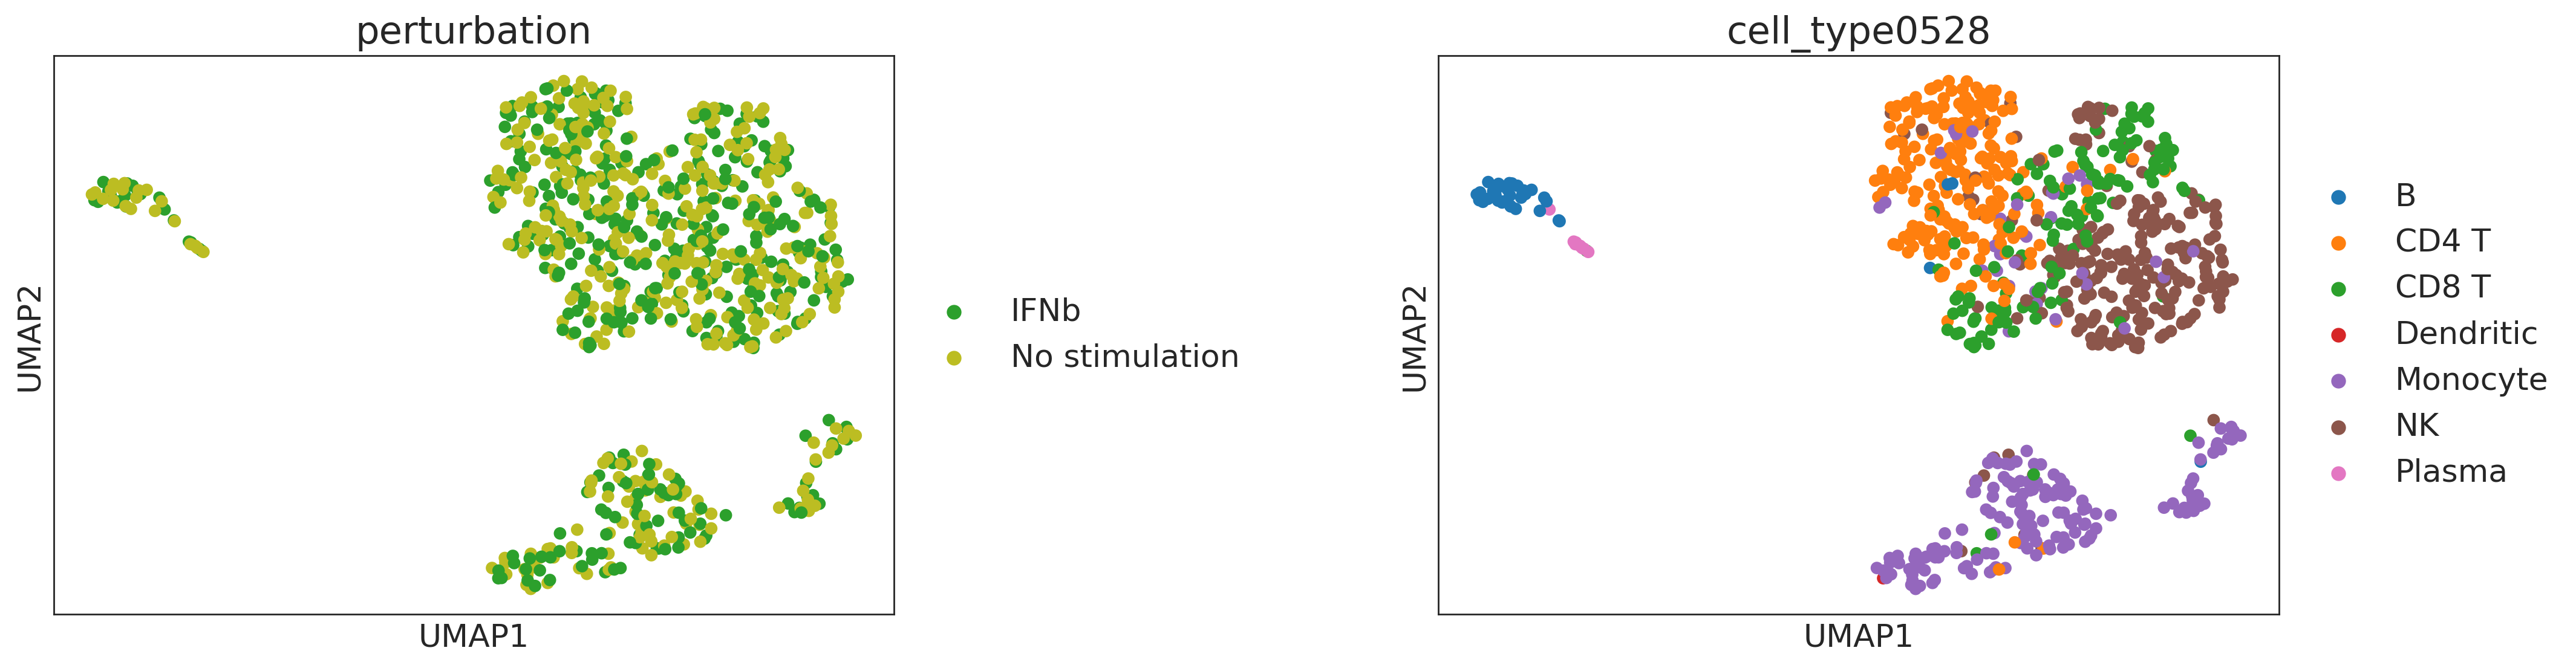

In [10]:
sc.pp.neighbors(ad, use_rep="cf")
sc.tl.umap(ad, random_state=1)
sc.pl.umap(ad, color=["perturbation", "cell_type0528"], wspace=0.5)

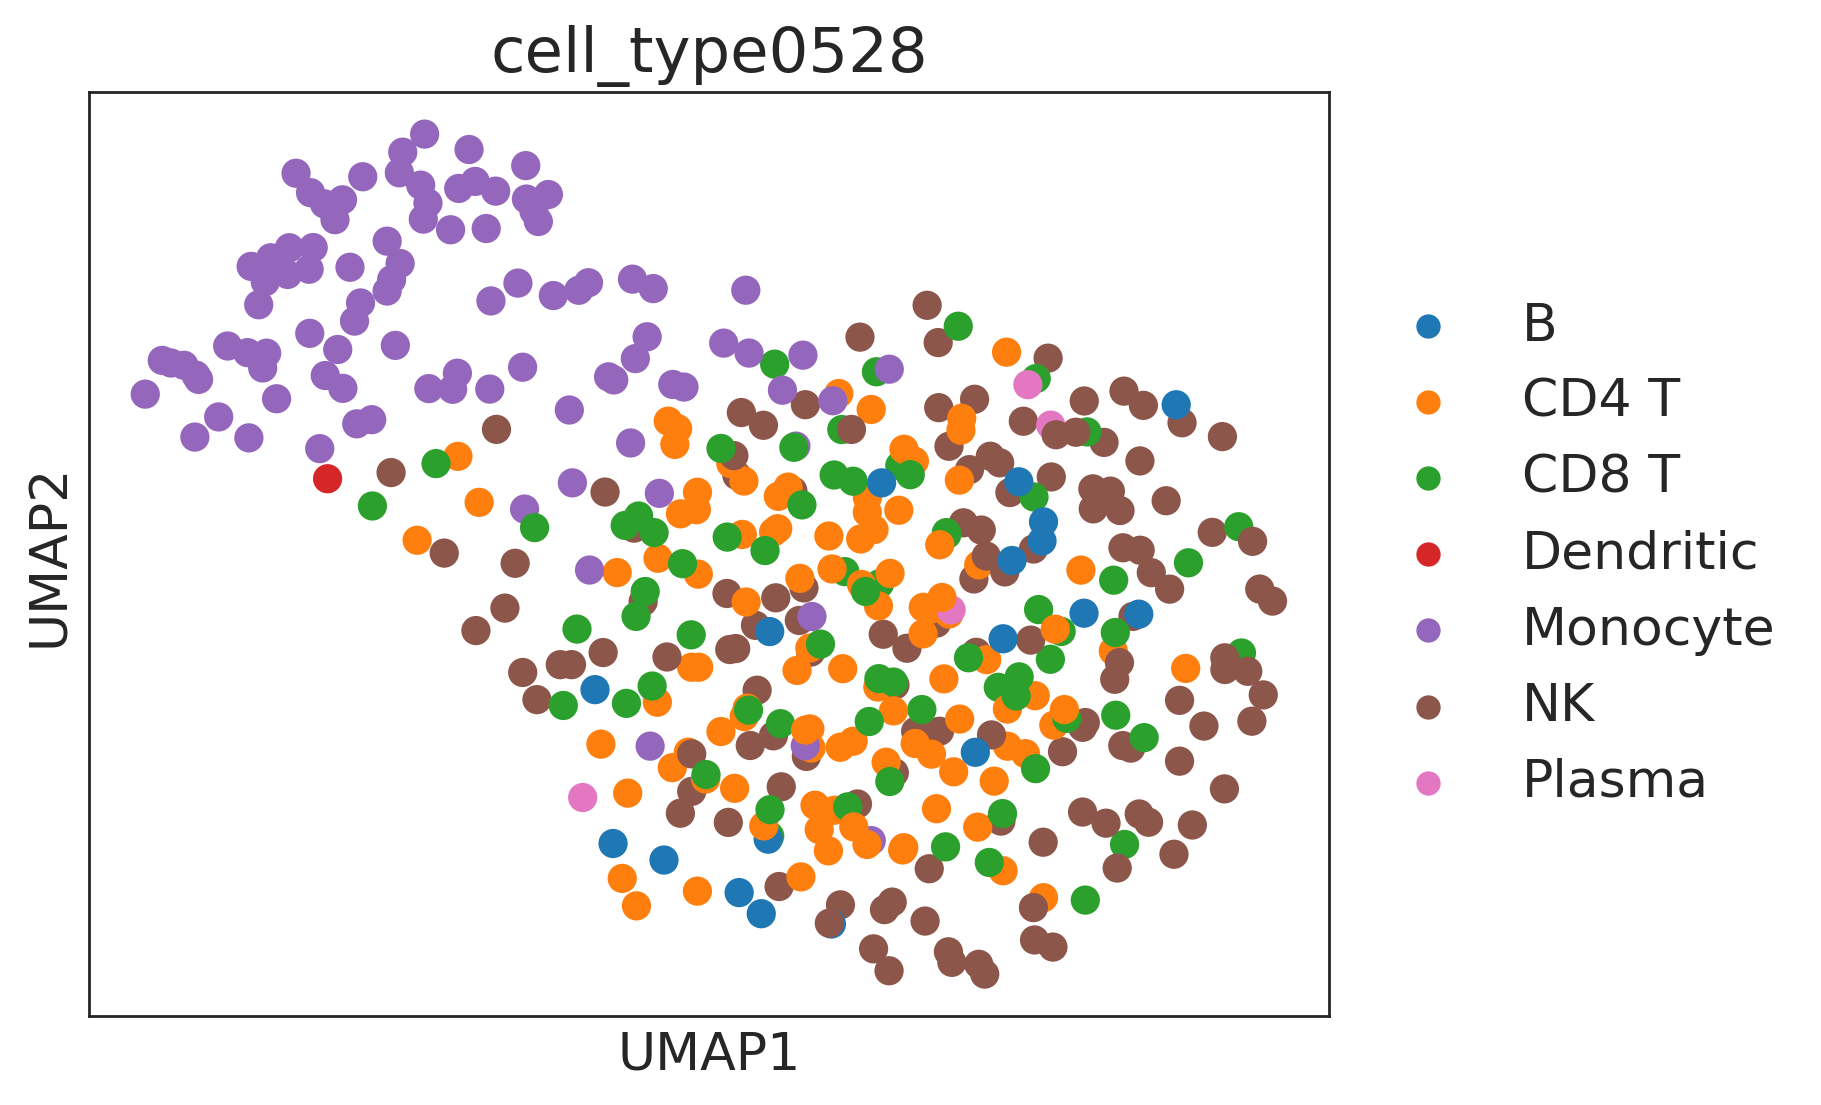

In [11]:
sc.pp.neighbors(de, use_rep="X_embedding")
sc.tl.umap(de)
sc.pl.umap(de, color=["cell_type0528"])

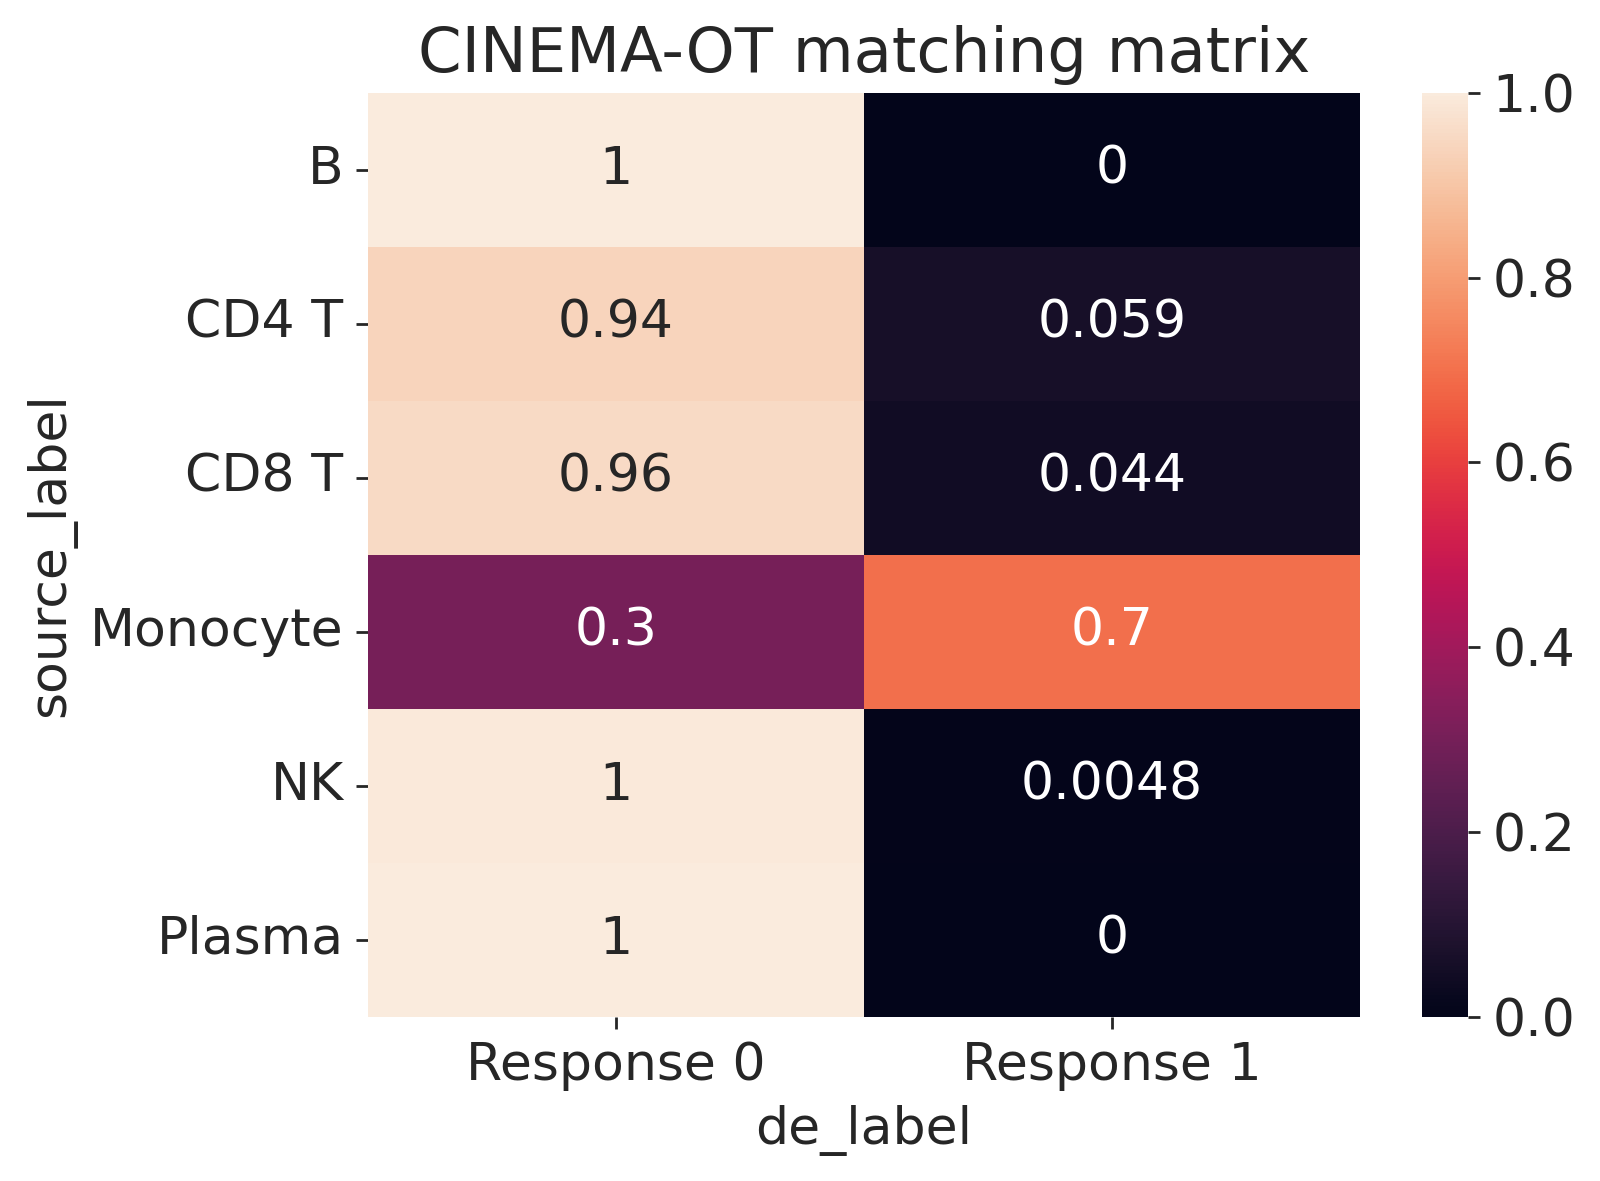

In [12]:
cot.plot_vis_matching(
    ad,
    de,
    pert_key="perturbation",
    control="No stimulation",
    de_label=None,
    source_label="cell_type0528",
    normalize="row",
    min_val=0.05,
)

The minimal dataset only includes two pairwise conditions (IFNb, control).
In the case with combinatorial perturbations, the function `Cinemaot.synergy` provides a wrapper for returning the synergy AnnData object syn with metadata and the low dimensional embedding stored in syn.obsm['X_embedding'].

## Generating pseudobulk profiles with CINEMA-OT

In this implementation, given the emerging need of analyzing cohort level scRNA-seq data, we also provide a highly customized function that enables generating pseudobulk profiles accounting the possible heterogenous treatment effect space. The pseudobulk profiles are aggregated by the confounder space (or other given metadata labels in label_list) and the treatment effect space clustering. The intuition is that all covariates apart from the treatment should be well modeled by the CINEMA-OT confounder space.

In [13]:
de = cot.causaleffect(
    adata,
    pert_key="perturbation",
    control="No stimulation",
    return_matching=True,
    thres=0.5,
    smoothness=1e-5,
    eps=1e-3,
    solver="Sinkhorn",
    preweight_label="cell_type0528",
)
adata_pb = cot.generate_pseudobulk(adata, de, pert_key="perturbation", control="No stimulation", label_list=None)
adata_pb

AnnData object with n_obs × n_vars = 20 × 773
    obs: 'ct', 'ptb'

## Treatment synergy analysis

If a dataset, which includes multiple treatments performed in combination, is available, we can use the synergy-effect metric to compare the effect predicted by CINEMA-OT with the actual experimental results.
For this purpose, we use the extended version of the cinemaot_example dataset used above:

In [14]:
adata_extended = pt.dt.dong_2023()

Output()

In [15]:
adata_extended

AnnData object with n_obs × n_vars = 9209 × 773
    obs: 'perturbation', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'leiden', 'cell_type0528'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'cell_type0528_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'perturbation_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [16]:
adata_extended.obs["perturbation"].unique()

['IFNb', 'No stimulation', 'IFNg', 'IFNb+ IFNg']
Categories (4, object): ['IFNb', 'IFNb+ IFNg', 'IFNg', 'No stimulation']

As shown above, the dataset includes four treatments: IFNb, IFNg, and both in combination (IFN+IFNg).
Next, we calculate the synergy metric:

In [17]:
sc.pp.pca(adata_extended)
cot = pt.tl.Cinemaot()
combo = cot.synergy(
    adata_extended,
    pert_key="perturbation",
    base="No stimulation",
    A="IFNb",
    B="IFNg",
    AB="IFNb+ IFNg",
    thres=0.5,
    smoothness=1e-5,
    eps=1e-3,
    solver="Sinkhorn",
)

Furthermore, we can visualize the results:

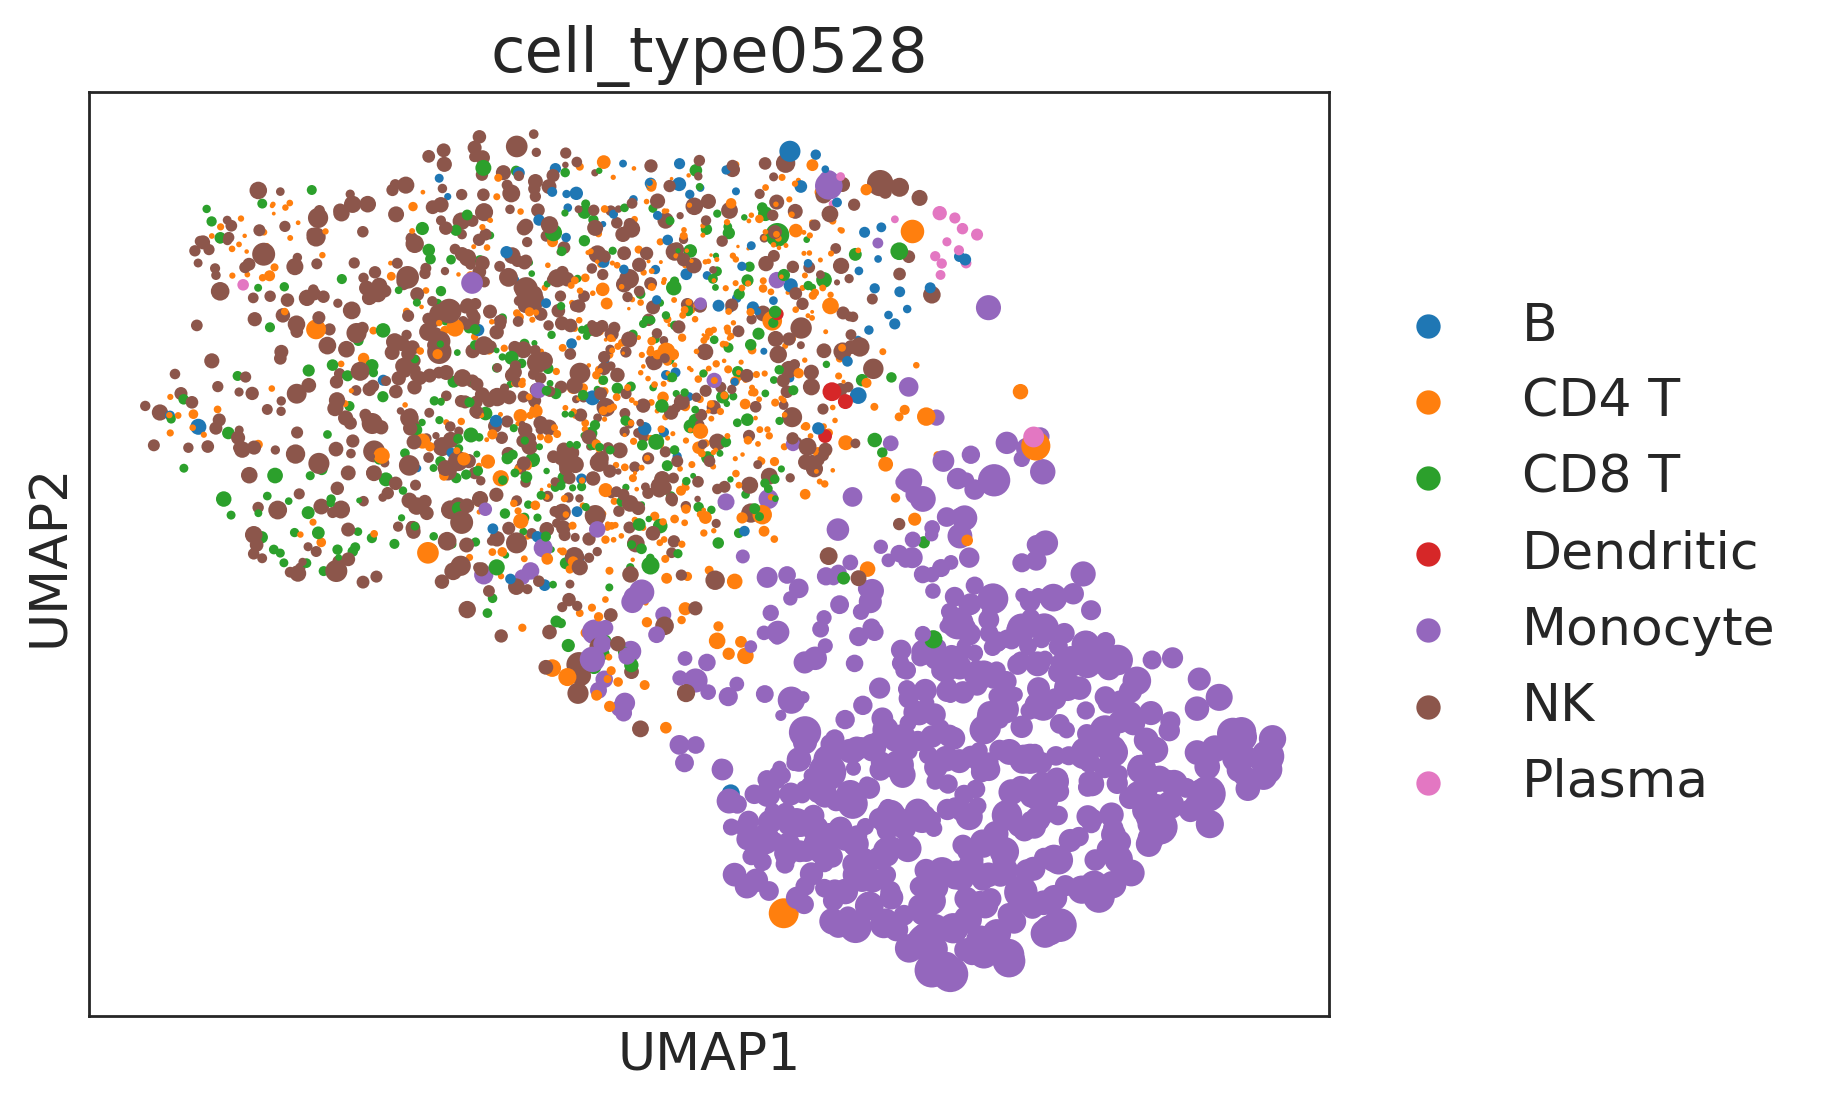

In [18]:
sc.pp.pca(combo)
sc.pp.neighbors(combo)
sc.tl.umap(combo)
synergyscore = np.linalg.norm(combo.X[:, np.abs(np.mean(combo.X, axis=0)) > 0.15], axis=1)
sc.pl.umap(combo, color=["cell_type0528"], wspace=0.5, size=0.3 * synergyscore**2)

## Conclusion

CINEMA-OT is a novel causal-inference approach in single-cell perturbation analysis that distinguishes confounding factors from true perturbation effects using optimal transport, enabling precise causal response identification and various advanced analytical techniques.

## References

1. Dong, M., Wang, B., Wei, J. et al. Causal identification of single-cell experimental perturbation effects with CINEMA-OT. Nat Methods 20, 1769–1779 (2023). https://doi.org/10.1038/s41592-023-02040-5